## 实验：梯度下降优化算法对比



### 实验概要

梯度下降法是最著名的优化算法之一，也是迄今优化神经网络时最常用的方法。同时，在每一个最新的深度学习库中都包含了各种优化的梯度下降法的实现。然而，这些算法通常是作为黑盒优化器使用，因此，很难对其优点和缺点的进行实际的解释。

### 实验目标

此前，我们已经介绍了：

- **批量梯度下降法 (Batch / Vanilla Gradient Descent)**
- **随机梯度下降法 (Stochastic Gradient Descent, SGD)**
- **小批量梯度下降法 (Mini-batch Gradient Descent)**

以及梯度下降优化算法 **动量法 (Momentum)**

本实验将继续介绍以下流行的自适应学习速率梯度下降优化算法，让你对不同的算法有直观的认识，以帮助你在后面的深度学习模型中选择合适的优化算法。

- **AdaGrad** 算法
- **RMSProp** 算法
- **AdaDelta** 算法
- **Adam** 算法

### 1. AdaGrad 算法

优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。举个例子，假设目标函数为 $f$，自变量为一个二维向量 $[x_1, x_2]^\top$，该向量中每一个元素在迭代时都使用相同的学习率。例如，在学习率为 $\eta$ 的梯度下降中，元素 $x_1$ 和 $x_2$ 都使用相同的学习率 $\eta$ 来自我迭代：

$$ x_1 \leftarrow x_1 - \eta \frac{\partial{f}}{\partial{x_1}}, \quad x_2 \leftarrow x_2 - \eta \frac{\partial{f}}{\partial{x_2}}. $$

在动量梯度中我们看到，当 $x_1$ 和 $x_2$ 的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上不发散。但这样会导致自变量在梯度值较小的维度上迭代过慢。动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。

下面，我们介绍 **AdaGrad** 算法，它根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题。

#### 1.1 AdaGrad 算法

 **AdaGrad** 算法会使用一个小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方的累加变量 $\boldsymbol{s}_t$。在时间步 0， **AdaGrad** 将$\boldsymbol{s}_0$ 中每个元素初始化为 0。在时间步 $t$，首先将小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方后累加到变量 $\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \boldsymbol{s}_{t-1} + \boldsymbol{g}_t \odot \boldsymbol{g}_t,$$

其中 $\odot$ 是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t,$$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，如 $10^{-6}$。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

#### 1.2 AdaGrad 特点

需要强调的是，小批量随机梯度按元素平方的累加变量 $\boldsymbol{s}_t$ 出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于 $\boldsymbol{s}_t$ 一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad 算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
# 导入3D绘图库
from mpl_toolkits import mplot3d 

# 魔法指令，使Matplotlib图形直接在Jupyter Notebook中显示
%matplotlib inline

调用之前定义的训练函数与梯度下降绘图函数：

In [2]:
# 该函数在后面将继续被调用
def train_2d(trainer):  
    # s1和s2是自变量状态，本章后续几节会使用
    x1, x2, s1, s2 = -5, -2, 0, 0  
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

# 该函数在后面将继续被调用
def show_trace_2d(f, results): 
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

#### 1.3 绘制 AdaGrad 梯度下降轨迹

下面我们仍然以目标函数 $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$ 为例观察 **AdaGrad** 算法对自变量的迭代轨迹。我们实现 **AdaGrad** 算法并使用和学习率 0.4。可以看到，自变量的迭代轨迹较平滑。但由于 $\boldsymbol{s}_t$ 的累加效果使学习率不断衰减，自变量在迭代后期的移动幅度较小。

epoch 20, x1 -2.382563, x2 -0.158591


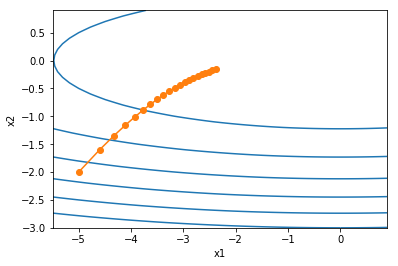

In [3]:
def adagrad_2d(x1, x2, s1, s2):
    # 前两项为自变量梯度
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

下面将学习率增大到 2。可以看到自变量更为迅速地逼近了最优解

epoch 20, x1 -0.002295, x2 -0.000000


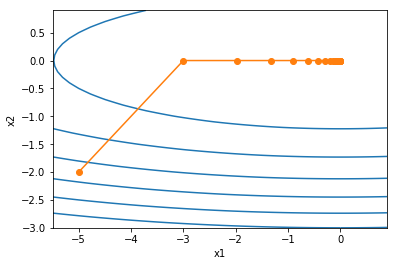

In [4]:
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

#### 1.4 AdaGrad 小结

- AdaGrad 算法在迭代过程中不断调整学习率，并让目标函数自变量中每个元素都分别拥有自己的学习率。
- 使用 AdaGrad 算法时，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。

### 2. RMSProp 算法

**AdaGrad** 算法中，因为调整学习率时分母上的变量 $\boldsymbol{s}_t$ 一直在累加按元素平方的小批量随机梯度，所以目标函数自变量每个元素的学习率在迭代过程中一直在降低（或不变）。因此，当学习率在迭代早期降得较快且当前解依然不佳时，**AdaGrad** 算法在迭代后期由于学习率过小，可能较难找到一个有用的解。为了解决这一问题，**RMSProp** 算法对 **AdaGrad** 算法做了一点小小的修改。[该算法源自 Coursera 上的一门课](https://www.coursera.org/lecture/deep-neural-network/rmsprop-BhJlm)。

#### 2.1 RMSProp 算法

在动量法梯度下降中介绍过指数加权移动平均。不同于 **AdaGrad** 算法里状态变量 $\boldsymbol{s}_t$ 是截至时间步$t$所有小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方和，**RMSProp** 算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数 $0 \leq \gamma < 1$，**RMSProp** 算法在时间步 $t>0$ 计算

$$\boldsymbol{s}_t \leftarrow \gamma \boldsymbol{s}_{t-1} + (1 - \gamma) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

和 **AdaGrad** 算法一样，**RMSProp** 算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \frac{\eta}{\sqrt{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t, $$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，如 $10^{-6}$。因为 **RMSProp** 算法的状态变量 $\boldsymbol{s}_t$ 是对平方项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ 的指数加权移动平均，所以可以看作最近 $1/(1-\gamma)$ 个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

照例，让我们先观察 **RMSProp** 算法对目标函数 $f(\boldsymbol{x})=0.1x_1^2+2x_2^2$ 中自变量的迭代轨迹。回忆在 **AdaGrad算法** 一节使用的学习率为 0.4 的 **AdaGrad** 算法，自变量在迭代后期的移动幅度较小。但在同样的学习率下，**RMSProp** 算法可以更快逼近最优解。

#### 2.2 绘制 RMSProp 梯度下降轨迹

epoch 20, x1 -0.010599, x2 0.000000


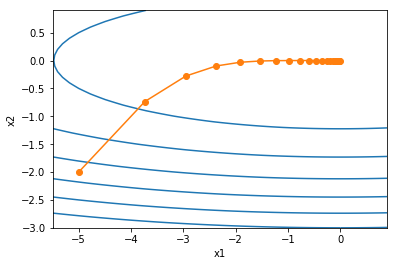

In [5]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

#### 2.3 RMSProp 小结

**RMSProp** 算法和 **AdaGrad** 算法的不同在于，**RMSProp** 算法使用了小批量随机梯度按元素平方的指数加权移动平均来调整学习率。

### 3 AdaDelta 算法

除了 **RMSProp** 算法以外，另一个常用优化算法 **AdaDelta** 算法也针对 **AdaGrad** 算法在迭代后期可能较难找到有用解的问题做了改进。有意思的是，**AdaDelta** 算法没有学习率这一超参数。

#### 3.1 AdaDelta 算法

**AdaDelta** 算法也像 **RMSProp** 算法一样，使用了小批量随机梯度 $\boldsymbol{g}_t$ 按元素平方的指数加权移动平均变量 $\boldsymbol{s}_t$。在时间步 0，它的所有元素被初始化为 0。给定超参数 $0 \leq \rho < 1$（对应RMSProp算法中的 $\gamma$），在时间步 $t>0$，同RMSProp算法一样计算

$$\boldsymbol{s}_t \leftarrow \rho \boldsymbol{s}_{t-1} + (1 - \rho) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

与 **RMSProp** 算法不同的是，**AdaDelta** 算法还维护一个额外的状态变量 $\Delta\boldsymbol{x}_t$，其元素同样在时间步 0 时被初始化为 0。我们使用 $\Delta\boldsymbol{x}_{t-1}$ 来计算自变量的变化量：

$$ \boldsymbol{g}_t' \leftarrow \sqrt{\frac{\Delta\boldsymbol{x}_{t-1} + \epsilon}{\boldsymbol{s}_t + \epsilon}} \odot \boldsymbol{g}_t, $$

其中 $\epsilon$ 是为了维持数值稳定性而添加的常数，如：$10^{-5}$。接着更新自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}'_t. $$

最后，我们使用 $\Delta\boldsymbol{x}_t$ 来记录自变量变化量 $\boldsymbol{g}'_t$ 按元素平方的指数加权移动平均：

$$\Delta\boldsymbol{x}_t \leftarrow \rho \Delta\boldsymbol{x}_{t-1} + (1 - \rho) \boldsymbol{g}'_t \odot \boldsymbol{g}'_t. $$

可以看到，如不考虑 $\epsilon$ 的影响，**AdaDelta** 算法与 **RMSProp** 算法的不同之处在于使用 $\sqrt{\Delta\boldsymbol{x}_{t-1}}$ 来替代超参数$\eta$。

#### 3.2 AdaDelta 小结

**AdaDelta** 算法没有学习率超参数，它通过使用有关自变量更新量平方的指数加权移动平均的项来替代 **RMSProp** 算法中的学习率。

### 4. Adam 算法

Adam 算法在 RMSProp 算法基础上对小批量随机梯度也做了指数加权移动平均。下面我们来介绍这个算法。

#### 4.1 Adam 算法

**Adam** 算法使用了动量变量 $\boldsymbol{v}_t$ 和 **RMSProp** 算法中小批量随机梯度按元素平方的指数加权移动平均变量 $\boldsymbol{s}_t$，并在时间步 0 将它们中每个元素初始化为 0。给定超参数 $0 \leq \beta_1 < 1$（算法作者建议设为 **0.9**），时间步 $t$ 的动量变量 $\boldsymbol{v}_t$ 即小批量随机梯度 $\boldsymbol{g}_t$ 的指数加权移动平均：

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

和 **RMSProp** 算法中一样，给定超参数 $0 \leq \beta_2 < 1$（算法作者建议设为 **0.999**）， 将小批量随机梯度按元素平方后的项 $\boldsymbol{g}_t \odot \boldsymbol{g}_t$ 做指数加权移动平均得到 $\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

由于我们将 $\boldsymbol{v}_0$ 和 $\boldsymbol{s}_0$ 中的元素都初始化为 0， 在时间步 $t$ 我们得到 $\boldsymbol{v}t = (1-\beta_1) \sum{i=1}^t \beta_1^{t-i} \boldsymbol{g}i$。将过去各时间步小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当 $t$ 较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当 $\beta_1 = 0.9$时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步 $t$，我们可以将 $\boldsymbol{v}_t$ 再除以 $1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为 1。这也叫作偏差修正。在 **Adam** 算法中，我们对变量 $\boldsymbol{v}_t$ 和 $\boldsymbol{s}_t$ 均作偏差修正：

$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$

接下来，**Adam** 算法使用以上偏差修正后的变量 $\hat{\boldsymbol{v}}_t$ 和 $\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},$$

其中 $\eta$ 是学习率，$\epsilon$ 是为了维持数值稳定性而添加的常数，如 $10^{-8}$。和 **AdaGrad** 算法、**RMSProp** 算法以及 **AdaDelta** 算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用 $\boldsymbol{g}_t'$ 迭代自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$

#### 4.2 Adam 小结

- **Adam** 算法在 **RMSProp** 算法的基础上对小批量随机梯度也做了指数加权移动平均。
- **Adam** 算法使用了偏差修正。

### 实验小结

在本实验中，你了解了 **AdaGrad** 算法、**RMSProp** 算法、**AdaDelta** 算法 以及 **Adam** 算法的基本原理，实际上，梯度下降优化算法还有很多，如下图：

<img src="./img/contours_evaluation_optimizers_14.gif" width="30%">

如上图所示，我们看到不同算法在损失曲面的等高线上走的不同路线。所有的算法都是从同一个点出发并选择不同路径到达最优点。注意：**Adagrad**，**Adadelta** 和 **RMSprop** 能够立即转移到正确的移动方向上并以类似的速度收敛，而 **动量法** 和 **NAG**（**Nesterov 加速梯度下降法**）会导致偏离，想像一下球从山上滚下的画面。然而，**NAG** 能够在偏离之后快速修正其路线，因为 **NAG** 通过对最优点的预见增强其响应能力。

<img src="./img/saddle_point_evaluation_optimizers_14.gif" width="40%">

如上图所示，展示了不同算法在鞍点处的行为，**鞍点** 即为一个点在一个维度上的斜率为正，而在其他维度上的斜率为负，鞍点对 **SGD** 的训练造成很大困难。这里注意，**SGD**，**动量法** 和 **NAG** 在鞍点处很难打破对称性，尽管后面两个算法最终设法逃离了鞍点。而 **Adagrad**，**RMSprop** 和 **Adadelta** 能够快速想着梯度为负的方向移动，其中 **Adadelta** 走在最前面。

正如我们所看到的，自适应学习速率的方法，即 **Adagrad**、 **Adadelta**、 **RMSprop** 和 **Adam**，在这些场景下最合适，并在这些场景下得到最好的收敛性。

那么，我们应该选择使用哪种优化算法呢？如果输入数据是稀疏的，选择任一自适应学习率算法可能会得到最好的结果。选用这类算法的另一个好处是无需调整学习率，选用默认值就可能达到最好的结果。

总的来说，**ARMSprop** 是 **Adagrad** 的扩展形式，用于处理在 **Adagrad** 中急速递减的学习率。**RMSprop** 与 **Adadelta** 相同，所不同的是 **Adadelta** 在更新规则中使用参数的均方根进行更新。最后，**Adam** 是将偏差校正和动量加入到 **RMSprop** 中。在这样的情况下，**RMSprop**、**Adadelta** 和 **Adam** 是很相似的算法并且在相似的环境中性能都不错。有论文指出：在优化后期由于梯度变得越来越稀疏，偏差校正能够帮助 **Adam** 微弱地胜过 **RMSprop**。综合看来， **Adam** 可能是最佳的选择。